## LSTMを使った株価予測

LSTMは時系列データの予測のために利用されます。時系列データには、ある場所の気温や、来客数、商品の価格など多岐にわたりますが、最もデータを入手しやすい株価をLSTMで予測を行ってみたいと思います。

ただし、ニューラルネットはあくまでも得られたデータの範囲内でしか予測する事が出来ず、想定外の状況になった場合、そのモデルはほぼ意味をなしません。

例えば、コロナショック前の1年前のデータを用いても、コロナショックを予測する事は出来ません。

株価の形成はランダムな要素もあり、LSTMで未来を予測するのは難しいとは思いますが、LSTMに慣れるためにやってみようと思います。

### github
- jupyter notebook形式のファイルは[こちら](https://github.com/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm_stock/lstm_nb.ipynb)

### google colaboratory
- google colaboratory で実行する場合は[こちら](https://colab.research.google.com/github/hiroshi0530/wa-src/tree/master/ml/lec/text/lstm_stock/lstm_nb.ipynb)

### 筆者の環境
筆者のOSはmacOSです。LinuxやUnixのコマンドとはオプションが異なります。

In [1]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.14.6
BuildVersion:	18G6032


In [2]:
!python -V

Python 3.8.5


基本的なライブラリとkerasをインポートしそのバージョンを確認しておきます。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

print('matplotlib version :', matplotlib.__version__)
print('scipy version :', scipy.__version__)
print('numpy version :', np.__version__)
print('tensorflow version : ', tf.__version__)
print('keras version : ', keras.__version__)

matplotlib version : 3.3.2
scipy version : 1.5.2
numpy version : 1.18.5
tensorflow version :  2.3.1
keras version :  2.4.0


## データの取得

今回は日経平均とアメリカのS&P500の株価のデータの予測を行います。データはそれぞれ以下のサイトからダウンロードしました。

### 日経平均のデータ

- https://indexes.nikkei.co.jp/nkave/index?type=download

### SP500のデータ

- https://kabuoji3.com/stock/download.php


## データの確認
まず最初に日経のデータを見てみます。

In [4]:
!ls 

lstm_nb.ipynb   lstm_nb.md      lstm_nb.py      lstm_nb.txt     lstm_nb_files   nikkei.csv      nikkei_utf8.csv sp500_2019.csv  sp500_2020.csv


In [5]:
%%bash
head nikkei.csv

�f�[�^���t,�I�l,�n�l,���l,���l
"2017/01/04","19594.16","19298.68","19594.16","19277.93"
"2017/01/05","19520.69","19602.10","19615.40","19473.28"
"2017/01/06","19454.33","19393.55","19472.37","19354.44"
"2017/01/10","19301.44","19414.83","19484.90","19255.35"
"2017/01/11","19364.67","19358.64","19402.17","19325.46"
"2017/01/12","19134.70","19300.19","19300.19","19069.02"
"2017/01/13","19287.28","19174.97","19299.36","19156.93"
"2017/01/16","19095.24","19219.13","19255.41","19061.27"
"2017/01/17","18813.53","19038.45","19043.91","18812.86"


文字コードがshift-jisになっているので、utf-8に直します。

In [6]:
%%bash
nkf --guess nikkei.csv

Shift_JIS (LF)


In [7]:
%%bash
nkf -w nikkei.csv > nikkei_utf8.csv

In [8]:
%%bash
head nikkei_utf8.csv

データ日付,終値,始値,高値,安値
"2017/01/04","19594.16","19298.68","19594.16","19277.93"
"2017/01/05","19520.69","19602.10","19615.40","19473.28"
"2017/01/06","19454.33","19393.55","19472.37","19354.44"
"2017/01/10","19301.44","19414.83","19484.90","19255.35"
"2017/01/11","19364.67","19358.64","19402.17","19325.46"
"2017/01/12","19134.70","19300.19","19300.19","19069.02"
"2017/01/13","19287.28","19174.97","19299.36","19156.93"
"2017/01/16","19095.24","19219.13","19255.41","19061.27"
"2017/01/17","18813.53","19038.45","19043.91","18812.86"


問題ないようなので、pandasで読み込みます。

In [9]:
df = pd.read_csv('nikkei_utf8.csv')

In [10]:
df.head()

,データ日付,終値,始値,高値,安値
0,2017/01/04,19594.16,19298.68,19594.16,19277.93
1,2017/01/05,19520.69,19602.10,19615.40,19473.28
2,2017/01/06,19454.33,19393.55,19472.37,19354.44
3,2017/01/10,19301.44,19414.83,19484.90,19255.35
4,2017/01/11,19364.67,19358.64,19402.17,19325.46


In [11]:
df.tail()

,データ日付,終値,始値,高値,安値
971,2020/12/24,26668.35,26635.11,26764.53,26605.26
972,2020/12/25,26656.61,26708.10,26716.61,26638.28
973,2020/12/28,26854.03,26691.29,26854.03,26664.60
974,2020/12/29,27568.15,26936.38,27602.52,26921.14
975,本資料は日経の著作物であり、本資料の全部又は一部を、いかなる形式によっても日経に無断で複写、...,NaN,NaN,NaN,NaN


最後の行に著作権に関する注意書きがありますが、これを削除します。複写や流布は行いません。

In [12]:
df.drop(index=975, inplace=True)

In [13]:
df.tail()

,データ日付,終値,始値,高値,安値
970,2020/12/23,26524.79,26580.43,26585.21,26414.74
971,2020/12/24,26668.35,26635.11,26764.53,26605.26
972,2020/12/25,26656.61,26708.10,26716.61,26638.28
973,2020/12/28,26854.03,26691.29,26854.03,26664.60
974,2020/12/29,27568.15,26936.38,27602.52,26921.14


データを可視化してみます。コロナショックで大きくへこんでいることがわかりますが、2020年の年末の時点では金融緩和の影響を受けて大幅に上がっています。

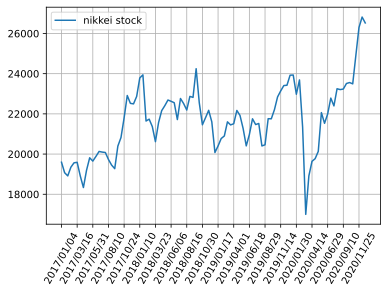

In [14]:
ticks = 10
xticks = ticks * 5 

plt.plot(df['データ日付'][::ticks], df['終値'][::ticks], label='nikkei stock')
plt.grid()
plt.legend()
plt.xticks(df['データ日付'][::xticks], rotation=60)
plt.show()

## データの準備

kerasに投入するためにデータを整えます。

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

NUM_LSTM = 100

x = np.array((df['データ日付']))
y = np.array((df['終値']))



# x = np.linspace(0, 5 * np.pi, 200)
# y = np.exp(-x / 5) * (np.cos(x))



n = len(y) - NUM_LSTM
l_x = np.zeros((n, NUM_LSTM))
l_y = np.zeros((n, NUM_LSTM))
for i in range(0, n):
  l_x[i] = y[i: i + NUM_LSTM]
  l_y[i] = y[i + 1: i + NUM_LSTM + 1]

l_x = l_x.reshape(n, NUM_LSTM, 1)
l_y = l_y.reshape(n, NUM_LSTM, 1)

In [16]:
print('shape : ', x.shape)
print('ndim : ', x.ndim)
print('data : ', x[:10])

shape :  (975,)
ndim :  1
data :  ['2017/01/04' '2017/01/05' '2017/01/06' '2017/01/10' '2017/01/11'
 '2017/01/12' '2017/01/13' '2017/01/16' '2017/01/17' '2017/01/18']


In [17]:
print('shape : ', y.shape)
print('ndim : ', y.ndim)
print('data : ', y[:10])

shape :  (975,)
ndim :  1
data :  [19594.16 19520.69 19454.33 19301.44 19364.67 19134.7  19287.28 19095.24
 18813.53 18894.37]


In [18]:
print(l_y.shape)
print(l_x.shape)

(875, 100, 1)
(875, 100, 1)


モデルの構築を定義する関数です。

In [19]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

NUM_MIDDLE = 40 
NUM_MIDDLE_01 = 100
NUM_MIDDLE_02 = 120

def build_lstm_model():
  # LSTMニューラルネットの構築
  # model = Sequential()
  # model.add(LSTM(NUM_MIDDLE, input_shape=(NUM_LSTM, 1), return_sequences=True))
  # model.add(Dense(1, activation="linear"))
  # model.compile(loss="mean_squared_error", optimizer="sgd")
  
  # LSTMニューラルネットの構築
  model = Sequential()
  model.add(LSTM(NUM_MIDDLE_01, input_shape = (NUM_LSTM, 1), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(NUM_MIDDLE_02, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.add(Activation("linear"))
  model.compile(loss="mse", optimizer='rmsprop')
  model.compile(loss="mean_squared_error", optimizer="sgd")
  
  return model

model = build_lstm_model()

# 詳細を確認します。

In [20]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          40800     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 120)          106080    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 120)          0         
_________________________________________________________________
dense (Dense)                (None, 100, 1)            121       
_________________________________________________________________
activation (Activation)      (None, 100, 1)            0         
Total params: 147,001
Trainable params: 147,001
Non-trainable params: 0
__________________________________________________

In [21]:
batch_size = 20
epochs = 5000

# validation_split で最後の10％を検証用に利用します
history = model.fit(l_x, l_y, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

Epoch 1/5000
40/40 [==============================] - 3s 77ms/step - loss: 23954814.0000 - val_loss: 2114200.5000
Epoch 2/5000
40/40 [==============================] - 3s 64ms/step - loss: 4033058.7500 - val_loss: 4427811.0000
Epoch 3/5000
40/40 [==============================] - 2s 60ms/step - loss: 3925872.7500 - val_loss: 4282510.0000
Epoch 4/5000
40/40 [==============================] - 2s 57ms/step - loss: 3849234.7500 - val_loss: 3879405.0000
Epoch 5/5000
40/40 [==============================] - 2s 56ms/step - loss: 3985638.7500 - val_loss: 2173635.2500
Epoch 6/5000
40/40 [==============================] - 2s 57ms/step - loss: 3859749.0000 - val_loss: 2373683.0000
Epoch 7/5000
40/40 [==============================] - 2s 57ms/step - loss: 3904291.7500 - val_loss: 2214273.0000
Epoch 8/5000
40/40 [==============================] - 2s 58ms/step - loss: 3818762.0000 - val_loss: 7220516.5000
Epoch 9/5000
40/40 [==============================] - 2s 57ms/step - loss: 3866692.2500 - val_l

Epoch 73/5000
40/40 [==============================] - 2s 55ms/step - loss: 3209425.5000 - val_loss: 2579790.2500
Epoch 74/5000
40/40 [==============================] - 2s 57ms/step - loss: 3319821.0000 - val_loss: 3595894.5000
Epoch 75/5000
40/40 [==============================] - 2s 55ms/step - loss: 3208618.0000 - val_loss: 3274171.7500
Epoch 76/5000
40/40 [==============================] - 2s 56ms/step - loss: 3189884.0000 - val_loss: 2743329.7500
Epoch 77/5000
40/40 [==============================] - 2s 55ms/step - loss: 3233653.7500 - val_loss: 3270695.2500
Epoch 78/5000
40/40 [==============================] - 2s 56ms/step - loss: 3202303.0000 - val_loss: 5950774.0000
Epoch 79/5000
40/40 [==============================] - 2s 57ms/step - loss: 3315551.2500 - val_loss: 2488124.2500
Epoch 80/5000
40/40 [==============================] - 2s 54ms/step - loss: 3280977.7500 - val_loss: 1992212.0000
Epoch 81/5000
40/40 [==============================] - 2s 57ms/step - loss: 3230049.5000

40/40 [==============================] - 2s 60ms/step - loss: 2831361.7500 - val_loss: 3412821.0000
Epoch 145/5000
40/40 [==============================] - 2s 60ms/step - loss: 2954772.2500 - val_loss: 1997136.0000
Epoch 146/5000
40/40 [==============================] - 3s 64ms/step - loss: 2886310.7500 - val_loss: 4183015.2500
Epoch 147/5000
40/40 [==============================] - 3s 80ms/step - loss: 2863920.7500 - val_loss: 3319837.5000
Epoch 148/5000
40/40 [==============================] - 3s 66ms/step - loss: 2910247.2500 - val_loss: 3684633.5000
Epoch 149/5000
40/40 [==============================] - 2s 61ms/step - loss: 2868677.5000 - val_loss: 3486483.7500
Epoch 150/5000
40/40 [==============================] - 3s 64ms/step - loss: 2868712.2500 - val_loss: 3293278.5000
Epoch 151/5000
40/40 [==============================] - 2s 61ms/step - loss: 2800910.2500 - val_loss: 1905486.1250
Epoch 152/5000
40/40 [==============================] - 2s 60ms/step - loss: 2818667.7500 - val

40/40 [==============================] - 3s 65ms/step - loss: 2547744.0000 - val_loss: 3567735.2500
Epoch 216/5000
40/40 [==============================] - 3s 65ms/step - loss: 2566937.0000 - val_loss: 5482410.0000
Epoch 217/5000
40/40 [==============================] - 3s 68ms/step - loss: 2536080.0000 - val_loss: 3510686.5000
Epoch 218/5000
40/40 [==============================] - 3s 72ms/step - loss: 2618305.2500 - val_loss: 4679496.5000
Epoch 219/5000
40/40 [==============================] - 3s 68ms/step - loss: 2614449.7500 - val_loss: 2904692.7500
Epoch 220/5000
40/40 [==============================] - 3s 65ms/step - loss: 2651212.5000 - val_loss: 3650926.5000
Epoch 221/5000
40/40 [==============================] - 3s 69ms/step - loss: 2613221.5000 - val_loss: 4978397.5000
Epoch 222/5000
40/40 [==============================] - 3s 63ms/step - loss: 2522022.0000 - val_loss: 7207608.5000
Epoch 223/5000
40/40 [==============================] - 3s 73ms/step - loss: 2615078.5000 - val

40/40 [==============================] - 3s 74ms/step - loss: 2435368.7500 - val_loss: 2935064.7500
Epoch 287/5000
40/40 [==============================] - 3s 72ms/step - loss: 2401819.5000 - val_loss: 2463578.5000
Epoch 288/5000
40/40 [==============================] - 3s 73ms/step - loss: 2485137.5000 - val_loss: 2403341.7500
Epoch 289/5000
40/40 [==============================] - 3s 71ms/step - loss: 2409240.5000 - val_loss: 6294208.0000
Epoch 290/5000
40/40 [==============================] - 3s 70ms/step - loss: 2449186.5000 - val_loss: 3102713.5000
Epoch 291/5000
40/40 [==============================] - 3s 73ms/step - loss: 2413257.2500 - val_loss: 3227641.5000
Epoch 292/5000
40/40 [==============================] - 3s 69ms/step - loss: 2443269.2500 - val_loss: 3197715.7500
Epoch 293/5000
40/40 [==============================] - 3s 71ms/step - loss: 2360672.7500 - val_loss: 3446531.2500
Epoch 294/5000
40/40 [==============================] - 3s 71ms/step - loss: 2373848.5000 - val

40/40 [==============================] - 3s 83ms/step - loss: 2332683.0000 - val_loss: 5643296.5000
Epoch 358/5000
40/40 [==============================] - 3s 76ms/step - loss: 2286876.2500 - val_loss: 6158680.0000
Epoch 359/5000
40/40 [==============================] - 3s 85ms/step - loss: 2271092.7500 - val_loss: 4337068.0000
Epoch 360/5000
40/40 [==============================] - 3s 86ms/step - loss: 2393622.2500 - val_loss: 6525075.5000
Epoch 361/5000
40/40 [==============================] - 4s 88ms/step - loss: 2293749.0000 - val_loss: 4752567.5000
Epoch 362/5000
40/40 [==============================] - 4s 88ms/step - loss: 2270733.7500 - val_loss: 4169251.7500
Epoch 363/5000
40/40 [==============================] - 3s 81ms/step - loss: 2406991.2500 - val_loss: 5751966.0000
Epoch 364/5000
40/40 [==============================] - 3s 85ms/step - loss: 2328877.0000 - val_loss: 3956799.0000
Epoch 365/5000
40/40 [==============================] - 3s 85ms/step - loss: 2318131.7500 - val

40/40 [==============================] - 3s 79ms/step - loss: 2182550.5000 - val_loss: 5057007.0000
Epoch 429/5000
40/40 [==============================] - 3s 80ms/step - loss: 2282061.0000 - val_loss: 4873340.0000
Epoch 430/5000
40/40 [==============================] - 3s 81ms/step - loss: 2218627.2500 - val_loss: 3721352.7500
Epoch 431/5000
40/40 [==============================] - 3s 86ms/step - loss: 2268791.5000 - val_loss: 8691594.0000
Epoch 432/5000
40/40 [==============================] - 4s 99ms/step - loss: 2227752.0000 - val_loss: 5789110.0000
Epoch 433/5000
40/40 [==============================] - 4s 89ms/step - loss: 2269347.0000 - val_loss: 3979413.0000
Epoch 434/5000
40/40 [==============================] - 3s 76ms/step - loss: 2199283.5000 - val_loss: 9336310.0000
Epoch 435/5000
40/40 [==============================] - 4s 94ms/step - loss: 2267534.2500 - val_loss: 6353405.0000
Epoch 436/5000
40/40 [==============================] - 4s 104ms/step - loss: 2301740.5000 - va

40/40 [==============================] - 3s 67ms/step - loss: 2239074.5000 - val_loss: 8494145.0000
Epoch 500/5000
40/40 [==============================] - 2s 59ms/step - loss: 2216278.7500 - val_loss: 5372566.0000
Epoch 501/5000
40/40 [==============================] - 3s 79ms/step - loss: 2214792.5000 - val_loss: 4503886.0000
Epoch 502/5000
40/40 [==============================] - 3s 77ms/step - loss: 2249677.7500 - val_loss: 6323186.0000
Epoch 503/5000
40/40 [==============================] - 3s 84ms/step - loss: 2187303.7500 - val_loss: 3838131.0000
Epoch 504/5000
40/40 [==============================] - 3s 81ms/step - loss: 2219097.7500 - val_loss: 4860254.0000
Epoch 505/5000
40/40 [==============================] - 3s 68ms/step - loss: 2193392.0000 - val_loss: 3663007.0000
Epoch 506/5000
40/40 [==============================] - 3s 73ms/step - loss: 2226268.0000 - val_loss: 4211217.5000
Epoch 507/5000
40/40 [==============================] - 3s 76ms/step - loss: 2202356.5000 - val

40/40 [==============================] - 3s 80ms/step - loss: 2257330.5000 - val_loss: 3141093.5000
Epoch 571/5000
40/40 [==============================] - 4s 93ms/step - loss: 2271359.7500 - val_loss: 2140309.5000
Epoch 572/5000
40/40 [==============================] - 4s 107ms/step - loss: 2258470.5000 - val_loss: 3931715.0000
Epoch 573/5000
40/40 [==============================] - 3s 86ms/step - loss: 2194429.0000 - val_loss: 3948206.5000
Epoch 574/5000
40/40 [==============================] - 3s 79ms/step - loss: 2239297.7500 - val_loss: 4504539.0000
Epoch 575/5000
40/40 [==============================] - 3s 78ms/step - loss: 2232085.2500 - val_loss: 3381223.7500
Epoch 576/5000
40/40 [==============================] - 3s 77ms/step - loss: 2127490.0000 - val_loss: 3048651.0000
Epoch 577/5000
40/40 [==============================] - 3s 79ms/step - loss: 2180436.7500 - val_loss: 2363277.7500
Epoch 578/5000
40/40 [==============================] - 3s 79ms/step - loss: 2276756.7500 - va

40/40 [==============================] - 2s 56ms/step - loss: 2153378.0000 - val_loss: 3995909.7500
Epoch 642/5000
40/40 [==============================] - 2s 58ms/step - loss: 2177258.7500 - val_loss: 3988861.7500
Epoch 643/5000
40/40 [==============================] - 2s 56ms/step - loss: 2120684.0000 - val_loss: 3137707.0000
Epoch 644/5000
40/40 [==============================] - 2s 57ms/step - loss: 2141296.5000 - val_loss: 2756765.0000
Epoch 645/5000
40/40 [==============================] - 2s 57ms/step - loss: 2159532.0000 - val_loss: 4058405.0000
Epoch 646/5000
40/40 [==============================] - 2s 56ms/step - loss: 2118322.5000 - val_loss: 7429064.5000
Epoch 647/5000
40/40 [==============================] - 2s 55ms/step - loss: 2155348.0000 - val_loss: 2078115.6250
Epoch 648/5000
40/40 [==============================] - 2s 56ms/step - loss: 2188647.7500 - val_loss: 2635615.5000
Epoch 649/5000
40/40 [==============================] - 2s 57ms/step - loss: 2164526.2500 - val

40/40 [==============================] - 2s 61ms/step - loss: 2246587.0000 - val_loss: 3610423.2500
Epoch 713/5000
40/40 [==============================] - 2s 58ms/step - loss: 2164358.2500 - val_loss: 5495694.0000
Epoch 714/5000
40/40 [==============================] - 2s 59ms/step - loss: 2206542.0000 - val_loss: 2911096.5000
Epoch 715/5000
40/40 [==============================] - 2s 61ms/step - loss: 2236267.2500 - val_loss: 2547526.2500
Epoch 716/5000
40/40 [==============================] - 3s 63ms/step - loss: 2218004.2500 - val_loss: 4986667.0000
Epoch 717/5000
40/40 [==============================] - 2s 59ms/step - loss: 2182442.0000 - val_loss: 2947423.7500
Epoch 718/5000
40/40 [==============================] - 2s 59ms/step - loss: 2212199.0000 - val_loss: 2136769.5000
Epoch 719/5000
40/40 [==============================] - 2s 61ms/step - loss: 2160583.0000 - val_loss: 2763150.5000
Epoch 720/5000
40/40 [==============================] - 2s 60ms/step - loss: 2249805.5000 - val

40/40 [==============================] - 3s 63ms/step - loss: 2163922.2500 - val_loss: 6573067.5000
Epoch 784/5000
40/40 [==============================] - 3s 64ms/step - loss: 2263324.7500 - val_loss: 4069064.7500
Epoch 785/5000
40/40 [==============================] - 3s 64ms/step - loss: 2117965.0000 - val_loss: 4027564.7500
Epoch 786/5000
40/40 [==============================] - 3s 64ms/step - loss: 2124101.2500 - val_loss: 4395517.0000
Epoch 787/5000
40/40 [==============================] - 3s 64ms/step - loss: 2168074.2500 - val_loss: 2302610.5000
Epoch 788/5000
40/40 [==============================] - 3s 63ms/step - loss: 2203379.2500 - val_loss: 5897700.0000
Epoch 789/5000
40/40 [==============================] - 3s 67ms/step - loss: 2189078.2500 - val_loss: 2269920.7500
Epoch 790/5000
40/40 [==============================] - 2s 62ms/step - loss: 2170649.2500 - val_loss: 5957219.0000
Epoch 791/5000
40/40 [==============================] - 3s 67ms/step - loss: 2198160.0000 - val

40/40 [==============================] - 2s 62ms/step - loss: 2156524.2500 - val_loss: 3049899.7500
Epoch 855/5000
40/40 [==============================] - 3s 64ms/step - loss: 2160339.5000 - val_loss: 4947586.0000
Epoch 856/5000
40/40 [==============================] - 2s 62ms/step - loss: 2151699.2500 - val_loss: 10714571.0000
Epoch 857/5000
40/40 [==============================] - 3s 66ms/step - loss: 2231909.7500 - val_loss: 4291998.0000
Epoch 858/5000
40/40 [==============================] - 3s 66ms/step - loss: 2243967.7500 - val_loss: 3894059.7500
Epoch 859/5000
40/40 [==============================] - 3s 66ms/step - loss: 2130495.5000 - val_loss: 4528028.5000
Epoch 860/5000
40/40 [==============================] - 2s 61ms/step - loss: 2147867.0000 - val_loss: 2407515.5000
Epoch 861/5000
40/40 [==============================] - 3s 63ms/step - loss: 2193311.7500 - val_loss: 3903955.7500
Epoch 862/5000
40/40 [==============================] - 3s 63ms/step - loss: 2146262.7500 - va

40/40 [==============================] - 2s 60ms/step - loss: 2159188.5000 - val_loss: 2762952.7500
Epoch 926/5000
40/40 [==============================] - 2s 55ms/step - loss: 2302591.7500 - val_loss: 5597140.0000
Epoch 927/5000
40/40 [==============================] - 2s 55ms/step - loss: 2131859.7500 - val_loss: 5191144.0000
Epoch 928/5000
40/40 [==============================] - 2s 53ms/step - loss: 2152985.5000 - val_loss: 12149918.0000
Epoch 929/5000
40/40 [==============================] - 2s 55ms/step - loss: 2209616.2500 - val_loss: 3166541.5000
Epoch 930/5000
40/40 [==============================] - 2s 56ms/step - loss: 2196620.7500 - val_loss: 3502949.0000
Epoch 931/5000
40/40 [==============================] - 3s 65ms/step - loss: 2184343.5000 - val_loss: 6896414.5000
Epoch 932/5000
40/40 [==============================] - 3s 63ms/step - loss: 2119119.7500 - val_loss: 5011248.5000
Epoch 933/5000
40/40 [==============================] - 2s 52ms/step - loss: 2168146.2500 - va

40/40 [==============================] - 2s 53ms/step - loss: 2123155.2500 - val_loss: 3309614.2500
Epoch 997/5000
40/40 [==============================] - 2s 53ms/step - loss: 2314362.7500 - val_loss: 4099549.7500
Epoch 998/5000
40/40 [==============================] - 2s 53ms/step - loss: 2160261.2500 - val_loss: 2435790.7500
Epoch 999/5000
40/40 [==============================] - 2s 54ms/step - loss: 2075937.1250 - val_loss: 2639953.5000
Epoch 1000/5000
40/40 [==============================] - 2s 53ms/step - loss: 2139210.5000 - val_loss: 2905678.2500
Epoch 1001/5000
40/40 [==============================] - 2s 53ms/step - loss: 2118873.2500 - val_loss: 2807092.2500
Epoch 1002/5000
40/40 [==============================] - 2s 52ms/step - loss: 2163011.7500 - val_loss: 2125296.2500
Epoch 1003/5000
40/40 [==============================] - 2s 53ms/step - loss: 2150538.5000 - val_loss: 5426801.5000
Epoch 1004/5000
40/40 [==============================] - 2s 53ms/step - loss: 2142655.0000 

Epoch 1067/5000
40/40 [==============================] - 2s 53ms/step - loss: 2147131.0000 - val_loss: 4705857.0000
Epoch 1068/5000
40/40 [==============================] - 2s 52ms/step - loss: 2091440.2500 - val_loss: 5239266.0000
Epoch 1069/5000
40/40 [==============================] - 2s 59ms/step - loss: 2199562.2500 - val_loss: 4906835.5000
Epoch 1070/5000
40/40 [==============================] - 2s 57ms/step - loss: 2138821.2500 - val_loss: 2265536.0000
Epoch 1071/5000
40/40 [==============================] - 2s 61ms/step - loss: 2191793.5000 - val_loss: 5546197.5000
Epoch 1072/5000
40/40 [==============================] - 2s 58ms/step - loss: 2157839.5000 - val_loss: 3610568.0000
Epoch 1073/5000
40/40 [==============================] - 2s 57ms/step - loss: 2107874.0000 - val_loss: 5615068.5000
Epoch 1074/5000
40/40 [==============================] - 2s 54ms/step - loss: 2152483.5000 - val_loss: 7166901.0000
Epoch 1075/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 54ms/step - loss: 2203292.0000 - val_loss: 5333994.0000
Epoch 1138/5000
40/40 [==============================] - 2s 53ms/step - loss: 2215248.7500 - val_loss: 2384044.2500
Epoch 1139/5000
40/40 [==============================] - 2s 54ms/step - loss: 2133911.0000 - val_loss: 2206692.2500
Epoch 1140/5000
40/40 [==============================] - 2s 52ms/step - loss: 2126761.2500 - val_loss: 3648863.0000
Epoch 1141/5000
40/40 [==============================] - 2s 53ms/step - loss: 2102551.5000 - val_loss: 1964084.3750
Epoch 1142/5000
40/40 [==============================] - 2s 53ms/step - loss: 2125896.5000 - val_loss: 5098234.0000
Epoch 1143/5000
40/40 [==============================] - 2s 54ms/step - loss: 2140376.7500 - val_loss: 3604176.2500
Epoch 1144/5000
40/40 [==============================] - 2s 53ms/step - loss: 2118374.7500 - val_loss: 3758888.0000
Epoch 1145/5000
40/40 [==============================] - 2s 53ms/step - loss: 2118905.00

Epoch 1208/5000
40/40 [==============================] - 2s 53ms/step - loss: 2119307.0000 - val_loss: 8449265.0000
Epoch 1209/5000
40/40 [==============================] - 2s 52ms/step - loss: 2215516.0000 - val_loss: 3297266.5000
Epoch 1210/5000
40/40 [==============================] - 2s 53ms/step - loss: 2123656.5000 - val_loss: 7393883.5000
Epoch 1211/5000
40/40 [==============================] - 2s 55ms/step - loss: 2248498.0000 - val_loss: 10856025.0000
Epoch 1212/5000
40/40 [==============================] - 2s 53ms/step - loss: 2191335.5000 - val_loss: 5718916.5000
Epoch 1213/5000
40/40 [==============================] - 2s 52ms/step - loss: 2103504.7500 - val_loss: 2225500.0000
Epoch 1214/5000
40/40 [==============================] - 2s 53ms/step - loss: 2162270.2500 - val_loss: 5182362.0000
Epoch 1215/5000
40/40 [==============================] - 2s 53ms/step - loss: 2092440.5000 - val_loss: 3393132.0000
Epoch 1216/5000
40/40 [==============================] - 2s 52ms/step -

40/40 [==============================] - 3s 66ms/step - loss: 2142517.2500 - val_loss: 6072979.5000
Epoch 1279/5000
40/40 [==============================] - 2s 56ms/step - loss: 2134528.7500 - val_loss: 2981537.7500
Epoch 1280/5000
40/40 [==============================] - 2s 53ms/step - loss: 2233596.7500 - val_loss: 3132695.2500
Epoch 1281/5000
40/40 [==============================] - 2s 53ms/step - loss: 2182203.2500 - val_loss: 4306854.0000
Epoch 1282/5000
40/40 [==============================] - 2s 52ms/step - loss: 2181377.5000 - val_loss: 5784083.5000
Epoch 1283/5000
40/40 [==============================] - 2s 52ms/step - loss: 2172290.5000 - val_loss: 3350807.0000
Epoch 1284/5000
40/40 [==============================] - 2s 53ms/step - loss: 2128352.0000 - val_loss: 7270916.5000
Epoch 1285/5000
40/40 [==============================] - 2s 53ms/step - loss: 2202860.7500 - val_loss: 2984115.2500
Epoch 1286/5000
40/40 [==============================] - 2s 52ms/step - loss: 2151781.25

Epoch 1349/5000
40/40 [==============================] - 2s 55ms/step - loss: 2147701.5000 - val_loss: 3384336.0000
Epoch 1350/5000
40/40 [==============================] - 2s 53ms/step - loss: 2173206.5000 - val_loss: 2379263.0000
Epoch 1351/5000
40/40 [==============================] - 2s 53ms/step - loss: 2124477.0000 - val_loss: 3571842.2500
Epoch 1352/5000
40/40 [==============================] - 2s 52ms/step - loss: 2116297.2500 - val_loss: 4915165.5000
Epoch 1353/5000
40/40 [==============================] - 2s 53ms/step - loss: 2222125.2500 - val_loss: 3006821.0000
Epoch 1354/5000
40/40 [==============================] - 2s 54ms/step - loss: 2120983.2500 - val_loss: 1959041.6250
Epoch 1355/5000
40/40 [==============================] - 2s 53ms/step - loss: 2154932.2500 - val_loss: 2026113.5000
Epoch 1356/5000
40/40 [==============================] - 2s 52ms/step - loss: 2129889.7500 - val_loss: 8418775.0000
Epoch 1357/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2198506.5000 - val_loss: 2965479.0000
Epoch 1420/5000
40/40 [==============================] - 2s 53ms/step - loss: 2109724.2500 - val_loss: 3859671.0000
Epoch 1421/5000
40/40 [==============================] - 2s 52ms/step - loss: 2149829.5000 - val_loss: 5121722.0000
Epoch 1422/5000
40/40 [==============================] - 2s 52ms/step - loss: 2113920.2500 - val_loss: 3113755.7500
Epoch 1423/5000
40/40 [==============================] - 2s 52ms/step - loss: 2142143.0000 - val_loss: 4632170.0000
Epoch 1424/5000
40/40 [==============================] - 2s 53ms/step - loss: 2078574.6250 - val_loss: 6675396.5000
Epoch 1425/5000
40/40 [==============================] - 2s 52ms/step - loss: 2154994.7500 - val_loss: 4692017.0000
Epoch 1426/5000
40/40 [==============================] - 2s 52ms/step - loss: 2108902.2500 - val_loss: 3121203.7500
Epoch 1427/5000
40/40 [==============================] - 2s 52ms/step - loss: 2263412.50

Epoch 1490/5000
40/40 [==============================] - 2s 53ms/step - loss: 2151437.7500 - val_loss: 4807677.5000
Epoch 1491/5000
40/40 [==============================] - 2s 53ms/step - loss: 2124665.7500 - val_loss: 2928777.0000
Epoch 1492/5000
40/40 [==============================] - 2s 52ms/step - loss: 2138858.2500 - val_loss: 3661137.0000
Epoch 1493/5000
40/40 [==============================] - 2s 52ms/step - loss: 2116089.2500 - val_loss: 5577118.5000
Epoch 1494/5000
40/40 [==============================] - 2s 53ms/step - loss: 2157639.7500 - val_loss: 6710747.5000
Epoch 1495/5000
40/40 [==============================] - 2s 53ms/step - loss: 2139528.0000 - val_loss: 5786739.5000
Epoch 1496/5000
40/40 [==============================] - 2s 52ms/step - loss: 2131758.7500 - val_loss: 3295592.7500
Epoch 1497/5000
40/40 [==============================] - 2s 53ms/step - loss: 2097068.8750 - val_loss: 4252521.5000
Epoch 1498/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2075825.2500 - val_loss: 3544709.5000
Epoch 1561/5000
40/40 [==============================] - 2s 53ms/step - loss: 2149834.0000 - val_loss: 5556177.0000
Epoch 1562/5000
40/40 [==============================] - 2s 53ms/step - loss: 2151950.0000 - val_loss: 1786102.0000
Epoch 1563/5000
40/40 [==============================] - 2s 52ms/step - loss: 2141122.5000 - val_loss: 4261904.0000
Epoch 1564/5000
40/40 [==============================] - 2s 52ms/step - loss: 2098365.7500 - val_loss: 10430431.0000
Epoch 1565/5000
40/40 [==============================] - 2s 52ms/step - loss: 2176588.0000 - val_loss: 3040049.2500
Epoch 1566/5000
40/40 [==============================] - 2s 53ms/step - loss: 2163724.2500 - val_loss: 4754175.5000
Epoch 1567/5000
40/40 [==============================] - 2s 53ms/step - loss: 2117593.5000 - val_loss: 4416275.0000
Epoch 1568/5000
40/40 [==============================] - 2s 54ms/step - loss: 2072393.6

Epoch 1631/5000
40/40 [==============================] - 2s 53ms/step - loss: 2121236.7500 - val_loss: 3035804.7500
Epoch 1632/5000
40/40 [==============================] - 2s 55ms/step - loss: 2146059.0000 - val_loss: 2374772.7500
Epoch 1633/5000
40/40 [==============================] - 2s 55ms/step - loss: 2138027.5000 - val_loss: 2105585.5000
Epoch 1634/5000
40/40 [==============================] - 2s 53ms/step - loss: 2158321.2500 - val_loss: 2620953.2500
Epoch 1635/5000
40/40 [==============================] - 2s 52ms/step - loss: 2199202.7500 - val_loss: 4638691.5000
Epoch 1636/5000
40/40 [==============================] - 2s 53ms/step - loss: 2171692.0000 - val_loss: 3032062.2500
Epoch 1637/5000
40/40 [==============================] - 2s 52ms/step - loss: 2119770.2500 - val_loss: 3656914.5000
Epoch 1638/5000
40/40 [==============================] - 2s 53ms/step - loss: 2196007.5000 - val_loss: 4419134.5000
Epoch 1639/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2119943.7500 - val_loss: 1842308.8750
Epoch 1702/5000
40/40 [==============================] - 2s 52ms/step - loss: 2139322.0000 - val_loss: 3895048.7500
Epoch 1703/5000
40/40 [==============================] - 2s 52ms/step - loss: 2096523.5000 - val_loss: 2770051.0000
Epoch 1704/5000
40/40 [==============================] - 2s 53ms/step - loss: 2121255.7500 - val_loss: 4206774.0000
Epoch 1705/5000
40/40 [==============================] - 2s 53ms/step - loss: 2139414.0000 - val_loss: 4648753.5000
Epoch 1706/5000
40/40 [==============================] - 2s 52ms/step - loss: 2101024.2500 - val_loss: 4309621.0000
Epoch 1707/5000
40/40 [==============================] - 2s 52ms/step - loss: 2096956.1250 - val_loss: 3933947.7500
Epoch 1708/5000
40/40 [==============================] - 2s 52ms/step - loss: 2172929.7500 - val_loss: 4495438.0000
Epoch 1709/5000
40/40 [==============================] - 2s 52ms/step - loss: 2207016.25

Epoch 1772/5000
40/40 [==============================] - 2s 52ms/step - loss: 2126904.7500 - val_loss: 7741542.0000
Epoch 1773/5000
40/40 [==============================] - 2s 52ms/step - loss: 2183948.5000 - val_loss: 4597664.5000
Epoch 1774/5000
40/40 [==============================] - 2s 53ms/step - loss: 2105466.2500 - val_loss: 3840992.7500
Epoch 1775/5000
40/40 [==============================] - 2s 52ms/step - loss: 2196550.2500 - val_loss: 3051152.0000
Epoch 1776/5000
40/40 [==============================] - 2s 52ms/step - loss: 2106116.7500 - val_loss: 2345852.5000
Epoch 1777/5000
40/40 [==============================] - 2s 53ms/step - loss: 2116508.7500 - val_loss: 3362751.7500
Epoch 1778/5000
40/40 [==============================] - 2s 53ms/step - loss: 2168137.0000 - val_loss: 3518940.2500
Epoch 1779/5000
40/40 [==============================] - 2s 52ms/step - loss: 2080119.0000 - val_loss: 3067436.0000
Epoch 1780/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2175729.7500 - val_loss: 3017500.2500
Epoch 1843/5000
40/40 [==============================] - 2s 52ms/step - loss: 2203114.7500 - val_loss: 3380109.5000
Epoch 1844/5000
40/40 [==============================] - 2s 52ms/step - loss: 2190877.2500 - val_loss: 5036214.5000
Epoch 1845/5000
40/40 [==============================] - 2s 52ms/step - loss: 2068653.0000 - val_loss: 6175447.5000
Epoch 1846/5000
40/40 [==============================] - 2s 53ms/step - loss: 2185762.2500 - val_loss: 2807817.7500
Epoch 1847/5000
40/40 [==============================] - 2s 52ms/step - loss: 2153089.7500 - val_loss: 5263451.0000
Epoch 1848/5000
40/40 [==============================] - 2s 53ms/step - loss: 2129302.0000 - val_loss: 2691695.0000
Epoch 1849/5000
40/40 [==============================] - 2s 53ms/step - loss: 2137754.7500 - val_loss: 3699853.7500
Epoch 1850/5000
40/40 [==============================] - 2s 53ms/step - loss: 2154059.50

Epoch 1913/5000
40/40 [==============================] - 2s 53ms/step - loss: 2153841.2500 - val_loss: 4056022.5000
Epoch 1914/5000
40/40 [==============================] - 2s 54ms/step - loss: 2136869.5000 - val_loss: 5206406.0000
Epoch 1915/5000
40/40 [==============================] - 2s 52ms/step - loss: 2125972.7500 - val_loss: 4153144.2500
Epoch 1916/5000
40/40 [==============================] - 2s 52ms/step - loss: 2177224.7500 - val_loss: 2764295.0000
Epoch 1917/5000
40/40 [==============================] - 2s 52ms/step - loss: 2099801.5000 - val_loss: 8242976.0000
Epoch 1918/5000
40/40 [==============================] - 2s 53ms/step - loss: 2200227.0000 - val_loss: 4604341.5000
Epoch 1919/5000
40/40 [==============================] - 2s 53ms/step - loss: 2195001.2500 - val_loss: 4066526.5000
Epoch 1920/5000
40/40 [==============================] - 2s 53ms/step - loss: 2177557.7500 - val_loss: 5373739.5000
Epoch 1921/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2171954.0000 - val_loss: 6826225.5000
Epoch 1984/5000
40/40 [==============================] - 2s 52ms/step - loss: 2128101.2500 - val_loss: 1795962.8750
Epoch 1985/5000
40/40 [==============================] - 2s 53ms/step - loss: 2204068.5000 - val_loss: 2819338.2500
Epoch 1986/5000
40/40 [==============================] - 2s 52ms/step - loss: 2145035.7500 - val_loss: 3896901.7500
Epoch 1987/5000
40/40 [==============================] - 2s 52ms/step - loss: 2135350.7500 - val_loss: 3512673.7500
Epoch 1988/5000
40/40 [==============================] - 2s 54ms/step - loss: 2148160.2500 - val_loss: 4749889.0000
Epoch 1989/5000
40/40 [==============================] - 2s 53ms/step - loss: 2161688.5000 - val_loss: 2906731.0000
Epoch 1990/5000
40/40 [==============================] - 2s 53ms/step - loss: 2164381.5000 - val_loss: 3288831.2500
Epoch 1991/5000
40/40 [==============================] - 2s 52ms/step - loss: 2096777.25

Epoch 2054/5000
40/40 [==============================] - 2s 52ms/step - loss: 2093992.0000 - val_loss: 3216151.2500
Epoch 2055/5000
40/40 [==============================] - 2s 53ms/step - loss: 2141129.2500 - val_loss: 3558205.7500
Epoch 2056/5000
40/40 [==============================] - 2s 53ms/step - loss: 2154042.0000 - val_loss: 2171211.7500
Epoch 2057/5000
40/40 [==============================] - 2s 53ms/step - loss: 2146143.2500 - val_loss: 5602309.0000
Epoch 2058/5000
40/40 [==============================] - 2s 52ms/step - loss: 2140324.5000 - val_loss: 3896636.2500
Epoch 2059/5000
40/40 [==============================] - 2s 62ms/step - loss: 2150864.2500 - val_loss: 1855433.1250
Epoch 2060/5000
40/40 [==============================] - 3s 66ms/step - loss: 2175838.0000 - val_loss: 3646630.5000
Epoch 2061/5000
40/40 [==============================] - 2s 53ms/step - loss: 2109403.5000 - val_loss: 3771174.5000
Epoch 2062/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2142045.7500 - val_loss: 2459589.0000
Epoch 2125/5000
40/40 [==============================] - 2s 52ms/step - loss: 2139722.2500 - val_loss: 7576872.5000
Epoch 2126/5000
40/40 [==============================] - 2s 53ms/step - loss: 2106581.2500 - val_loss: 3456088.2500
Epoch 2127/5000
40/40 [==============================] - 2s 51ms/step - loss: 2122961.7500 - val_loss: 4616550.0000
Epoch 2128/5000
40/40 [==============================] - 2s 52ms/step - loss: 2189600.7500 - val_loss: 6528229.0000
Epoch 2129/5000
40/40 [==============================] - 2s 53ms/step - loss: 2116045.0000 - val_loss: 2264791.5000
Epoch 2130/5000
40/40 [==============================] - 2s 52ms/step - loss: 2196736.2500 - val_loss: 4128730.2500
Epoch 2131/5000
40/40 [==============================] - 2s 52ms/step - loss: 2152872.7500 - val_loss: 4015453.0000
Epoch 2132/5000
40/40 [==============================] - 2s 51ms/step - loss: 2149415.00

Epoch 2195/5000
40/40 [==============================] - 2s 53ms/step - loss: 2124647.5000 - val_loss: 2666696.2500
Epoch 2196/5000
40/40 [==============================] - 2s 54ms/step - loss: 2070667.2500 - val_loss: 2215069.2500
Epoch 2197/5000
40/40 [==============================] - 2s 54ms/step - loss: 2156330.5000 - val_loss: 6781936.5000
Epoch 2198/5000
40/40 [==============================] - 2s 53ms/step - loss: 2333401.2500 - val_loss: 2133679.2500
Epoch 2199/5000
40/40 [==============================] - 2s 53ms/step - loss: 2246523.2500 - val_loss: 3852067.2500
Epoch 2200/5000
40/40 [==============================] - 2s 53ms/step - loss: 2145485.0000 - val_loss: 2188079.2500
Epoch 2201/5000
40/40 [==============================] - 2s 52ms/step - loss: 2221557.0000 - val_loss: 4253922.0000
Epoch 2202/5000
40/40 [==============================] - 2s 52ms/step - loss: 2205716.5000 - val_loss: 4214685.5000
Epoch 2203/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 55ms/step - loss: 2112307.5000 - val_loss: 4719808.5000
Epoch 2266/5000
40/40 [==============================] - 2s 53ms/step - loss: 2074646.6250 - val_loss: 1882947.6250
Epoch 2267/5000
40/40 [==============================] - 2s 52ms/step - loss: 2196000.2500 - val_loss: 2416145.7500
Epoch 2268/5000
40/40 [==============================] - 2s 53ms/step - loss: 2161884.7500 - val_loss: 4137920.0000
Epoch 2269/5000
40/40 [==============================] - 2s 52ms/step - loss: 2117467.7500 - val_loss: 4060856.7500
Epoch 2270/5000
40/40 [==============================] - 2s 52ms/step - loss: 2160672.2500 - val_loss: 5158276.5000
Epoch 2271/5000
40/40 [==============================] - 2s 53ms/step - loss: 2151557.5000 - val_loss: 3110365.7500
Epoch 2272/5000
40/40 [==============================] - 2s 53ms/step - loss: 2128705.2500 - val_loss: 5115907.5000
Epoch 2273/5000
40/40 [==============================] - 2s 53ms/step - loss: 2181644.25

Epoch 2336/5000
40/40 [==============================] - 2s 52ms/step - loss: 2238993.7500 - val_loss: 2196037.2500
Epoch 2337/5000
40/40 [==============================] - 2s 52ms/step - loss: 2098436.0000 - val_loss: 4000205.0000
Epoch 2338/5000
40/40 [==============================] - 2s 52ms/step - loss: 2093877.8750 - val_loss: 4142955.2500
Epoch 2339/5000
40/40 [==============================] - 2s 53ms/step - loss: 2133222.5000 - val_loss: 2644947.5000
Epoch 2340/5000
40/40 [==============================] - 2s 52ms/step - loss: 2196785.2500 - val_loss: 3921257.5000
Epoch 2341/5000
40/40 [==============================] - 2s 52ms/step - loss: 2202447.0000 - val_loss: 4111872.2500
Epoch 2342/5000
40/40 [==============================] - 2s 55ms/step - loss: 2140207.7500 - val_loss: 2619834.2500
Epoch 2343/5000
40/40 [==============================] - 2s 54ms/step - loss: 2164622.0000 - val_loss: 2422220.2500
Epoch 2344/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2242150.7500 - val_loss: 5102931.0000
Epoch 2407/5000
40/40 [==============================] - 2s 51ms/step - loss: 2105475.7500 - val_loss: 5053039.5000
Epoch 2408/5000
40/40 [==============================] - 3s 65ms/step - loss: 2168908.5000 - val_loss: 6458299.5000
Epoch 2409/5000
40/40 [==============================] - 2s 62ms/step - loss: 2198335.5000 - val_loss: 4265560.5000
Epoch 2410/5000
40/40 [==============================] - 2s 53ms/step - loss: 2154519.7500 - val_loss: 13010268.0000
Epoch 2411/5000
40/40 [==============================] - 2s 53ms/step - loss: 2293373.0000 - val_loss: 2532595.2500
Epoch 2412/5000
40/40 [==============================] - 2s 53ms/step - loss: 2139103.2500 - val_loss: 2357846.2500
Epoch 2413/5000
40/40 [==============================] - 2s 52ms/step - loss: 2114889.0000 - val_loss: 3883556.2500
Epoch 2414/5000
40/40 [==============================] - 2s 55ms/step - loss: 2071110.3

Epoch 2477/5000
40/40 [==============================] - 2s 53ms/step - loss: 2114194.5000 - val_loss: 5509479.5000
Epoch 2478/5000
40/40 [==============================] - 2s 52ms/step - loss: 2189534.7500 - val_loss: 3314799.7500
Epoch 2479/5000
40/40 [==============================] - 2s 53ms/step - loss: 2084568.5000 - val_loss: 4012242.5000
Epoch 2480/5000
40/40 [==============================] - 2s 52ms/step - loss: 2109263.2500 - val_loss: 2532869.0000
Epoch 2481/5000
40/40 [==============================] - 2s 52ms/step - loss: 2169835.7500 - val_loss: 4074432.7500
Epoch 2482/5000
40/40 [==============================] - 2s 53ms/step - loss: 2125618.0000 - val_loss: 4225700.5000
Epoch 2483/5000
40/40 [==============================] - 2s 53ms/step - loss: 2166073.2500 - val_loss: 5795530.5000
Epoch 2484/5000
40/40 [==============================] - 2s 53ms/step - loss: 2242359.0000 - val_loss: 5957411.0000
Epoch 2485/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2161111.7500 - val_loss: 3002429.5000
Epoch 2548/5000
40/40 [==============================] - 2s 53ms/step - loss: 2111390.7500 - val_loss: 2559792.0000
Epoch 2549/5000
40/40 [==============================] - 2s 52ms/step - loss: 2144849.7500 - val_loss: 1782219.6250
Epoch 2550/5000
40/40 [==============================] - 2s 53ms/step - loss: 2278201.0000 - val_loss: 2699732.2500
Epoch 2551/5000
40/40 [==============================] - 2s 53ms/step - loss: 2156521.0000 - val_loss: 4577710.0000
Epoch 2552/5000
40/40 [==============================] - 2s 58ms/step - loss: 2090834.6250 - val_loss: 2884382.5000
Epoch 2553/5000
40/40 [==============================] - 2s 55ms/step - loss: 2097479.2500 - val_loss: 3778176.7500
Epoch 2554/5000
40/40 [==============================] - 2s 52ms/step - loss: 2133954.2500 - val_loss: 2506084.2500
Epoch 2555/5000
40/40 [==============================] - 2s 54ms/step - loss: 2096369.00

Epoch 2618/5000
40/40 [==============================] - 2s 52ms/step - loss: 2096708.1250 - val_loss: 4704762.0000
Epoch 2619/5000
40/40 [==============================] - 2s 53ms/step - loss: 2207732.5000 - val_loss: 2974178.2500
Epoch 2620/5000
40/40 [==============================] - 2s 52ms/step - loss: 2141426.7500 - val_loss: 3554003.0000
Epoch 2621/5000
40/40 [==============================] - 2s 54ms/step - loss: 2199532.0000 - val_loss: 3513675.2500
Epoch 2622/5000
40/40 [==============================] - 2s 55ms/step - loss: 2079429.0000 - val_loss: 6357870.0000
Epoch 2623/5000
40/40 [==============================] - 2s 55ms/step - loss: 2153964.2500 - val_loss: 3156787.7500
Epoch 2624/5000
40/40 [==============================] - 2s 53ms/step - loss: 2144931.5000 - val_loss: 3047449.0000
Epoch 2625/5000
40/40 [==============================] - 2s 52ms/step - loss: 2187094.2500 - val_loss: 8080513.5000
Epoch 2626/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2193108.7500 - val_loss: 7924859.5000
Epoch 2689/5000
40/40 [==============================] - 2s 57ms/step - loss: 2128140.2500 - val_loss: 2957232.2500
Epoch 2690/5000
40/40 [==============================] - 2s 54ms/step - loss: 2083805.6250 - val_loss: 5941890.5000
Epoch 2691/5000
40/40 [==============================] - 2s 52ms/step - loss: 2242120.0000 - val_loss: 2734807.2500
Epoch 2692/5000
40/40 [==============================] - 2s 53ms/step - loss: 2167661.0000 - val_loss: 8689873.0000
Epoch 2693/5000
40/40 [==============================] - 2s 54ms/step - loss: 2180685.5000 - val_loss: 3134241.5000
Epoch 2694/5000
40/40 [==============================] - 2s 54ms/step - loss: 2155224.2500 - val_loss: 2440243.0000
Epoch 2695/5000
40/40 [==============================] - 2s 53ms/step - loss: 2150306.5000 - val_loss: 5729011.0000
Epoch 2696/5000
40/40 [==============================] - 2s 53ms/step - loss: 2113899.50

Epoch 2759/5000
40/40 [==============================] - 2s 54ms/step - loss: 2090141.8750 - val_loss: 4112671.7500
Epoch 2760/5000
40/40 [==============================] - 2s 53ms/step - loss: 2155334.7500 - val_loss: 2000198.0000
Epoch 2761/5000
40/40 [==============================] - 2s 53ms/step - loss: 2130598.7500 - val_loss: 6592976.0000
Epoch 2762/5000
40/40 [==============================] - 2s 53ms/step - loss: 2171487.5000 - val_loss: 3642171.2500
Epoch 2763/5000
40/40 [==============================] - 2s 53ms/step - loss: 2139605.0000 - val_loss: 5607045.5000
Epoch 2764/5000
40/40 [==============================] - 2s 52ms/step - loss: 2129095.7500 - val_loss: 2781470.5000
Epoch 2765/5000
40/40 [==============================] - 2s 53ms/step - loss: 2168239.0000 - val_loss: 2588469.0000
Epoch 2766/5000
40/40 [==============================] - 2s 54ms/step - loss: 2148487.7500 - val_loss: 1793851.8750
Epoch 2767/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2252002.2500 - val_loss: 4884549.5000
Epoch 2830/5000
40/40 [==============================] - 2s 53ms/step - loss: 2193247.2500 - val_loss: 6858363.0000
Epoch 2831/5000
40/40 [==============================] - 2s 53ms/step - loss: 2109499.7500 - val_loss: 3120772.2500
Epoch 2832/5000
40/40 [==============================] - 2s 53ms/step - loss: 2136306.2500 - val_loss: 5249628.5000
Epoch 2833/5000
40/40 [==============================] - 2s 53ms/step - loss: 2076776.2500 - val_loss: 5034198.5000
Epoch 2834/5000
40/40 [==============================] - 2s 54ms/step - loss: 2106253.5000 - val_loss: 5845005.0000
Epoch 2835/5000
40/40 [==============================] - 2s 57ms/step - loss: 2090870.3750 - val_loss: 3237685.5000
Epoch 2836/5000
40/40 [==============================] - 2s 56ms/step - loss: 2135153.5000 - val_loss: 2284894.7500
Epoch 2837/5000
40/40 [==============================] - 2s 53ms/step - loss: 2121784.50

Epoch 2900/5000
40/40 [==============================] - 2s 53ms/step - loss: 2184235.5000 - val_loss: 4356273.5000
Epoch 2901/5000
40/40 [==============================] - 2s 53ms/step - loss: 2099011.7500 - val_loss: 2667475.0000
Epoch 2902/5000
40/40 [==============================] - 2s 52ms/step - loss: 2137232.0000 - val_loss: 5383651.5000
Epoch 2903/5000
40/40 [==============================] - 2s 52ms/step - loss: 2110471.7500 - val_loss: 4954110.0000
Epoch 2904/5000
40/40 [==============================] - 2s 53ms/step - loss: 2213524.2500 - val_loss: 2326284.7500
Epoch 2905/5000
40/40 [==============================] - 2s 52ms/step - loss: 2142458.2500 - val_loss: 6074873.5000
Epoch 2906/5000
40/40 [==============================] - 2s 53ms/step - loss: 2125483.5000 - val_loss: 2035517.5000
Epoch 2907/5000
40/40 [==============================] - 2s 54ms/step - loss: 2203311.5000 - val_loss: 1838965.6250
Epoch 2908/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2208713.2500 - val_loss: 4579920.0000
Epoch 2971/5000
40/40 [==============================] - 2s 53ms/step - loss: 2184168.7500 - val_loss: 3530766.5000
Epoch 2972/5000
40/40 [==============================] - 2s 53ms/step - loss: 2130750.7500 - val_loss: 2218576.2500
Epoch 2973/5000
40/40 [==============================] - 2s 53ms/step - loss: 2140740.7500 - val_loss: 2491483.2500
Epoch 2974/5000
40/40 [==============================] - 2s 53ms/step - loss: 2183444.2500 - val_loss: 4894155.5000
Epoch 2975/5000
40/40 [==============================] - 2s 53ms/step - loss: 2107117.0000 - val_loss: 3947055.7500
Epoch 2976/5000
40/40 [==============================] - 2s 53ms/step - loss: 2171872.5000 - val_loss: 3225783.2500
Epoch 2977/5000
40/40 [==============================] - 2s 54ms/step - loss: 2132274.0000 - val_loss: 3743781.5000
Epoch 2978/5000
40/40 [==============================] - 2s 52ms/step - loss: 2165411.25

Epoch 3041/5000
40/40 [==============================] - 2s 54ms/step - loss: 2127581.7500 - val_loss: 2657059.2500
Epoch 3042/5000
40/40 [==============================] - 2s 58ms/step - loss: 2134245.7500 - val_loss: 4773693.5000
Epoch 3043/5000
40/40 [==============================] - 2s 60ms/step - loss: 2122216.5000 - val_loss: 3710331.0000
Epoch 3044/5000
40/40 [==============================] - 2s 56ms/step - loss: 2093512.7500 - val_loss: 7531411.0000
Epoch 3045/5000
40/40 [==============================] - 2s 54ms/step - loss: 2178961.0000 - val_loss: 6087574.5000
Epoch 3046/5000
40/40 [==============================] - 2s 53ms/step - loss: 2114787.5000 - val_loss: 3841159.2500
Epoch 3047/5000
40/40 [==============================] - 2s 53ms/step - loss: 2086506.7500 - val_loss: 2597607.5000
Epoch 3048/5000
40/40 [==============================] - 2s 57ms/step - loss: 2152719.0000 - val_loss: 3502207.0000
Epoch 3049/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2162042.2500 - val_loss: 4529110.0000
Epoch 3112/5000
40/40 [==============================] - 2s 52ms/step - loss: 2118496.0000 - val_loss: 4417271.0000
Epoch 3113/5000
40/40 [==============================] - 2s 55ms/step - loss: 2110864.7500 - val_loss: 3389379.0000
Epoch 3114/5000
40/40 [==============================] - 2s 53ms/step - loss: 2133221.2500 - val_loss: 5450230.0000
Epoch 3115/5000
40/40 [==============================] - 2s 54ms/step - loss: 2116500.5000 - val_loss: 2195163.7500
Epoch 3116/5000
40/40 [==============================] - 2s 53ms/step - loss: 2117544.0000 - val_loss: 1875255.6250
Epoch 3117/5000
40/40 [==============================] - 2s 53ms/step - loss: 2258506.0000 - val_loss: 2205211.5000
Epoch 3118/5000
40/40 [==============================] - 2s 53ms/step - loss: 2175663.0000 - val_loss: 4791330.5000
Epoch 3119/5000
40/40 [==============================] - 2s 53ms/step - loss: 2154632.25

Epoch 3182/5000
40/40 [==============================] - 2s 53ms/step - loss: 2133126.7500 - val_loss: 2188826.5000
Epoch 3183/5000
40/40 [==============================] - 2s 53ms/step - loss: 2172812.7500 - val_loss: 2518757.2500
Epoch 3184/5000
40/40 [==============================] - 2s 52ms/step - loss: 2080009.7500 - val_loss: 4519124.0000
Epoch 3185/5000
40/40 [==============================] - 2s 53ms/step - loss: 2206387.0000 - val_loss: 1956924.7500
Epoch 3186/5000
40/40 [==============================] - 2s 53ms/step - loss: 2178787.7500 - val_loss: 3167156.7500
Epoch 3187/5000
40/40 [==============================] - 2s 54ms/step - loss: 2157060.7500 - val_loss: 2824031.2500
Epoch 3188/5000
40/40 [==============================] - 2s 54ms/step - loss: 2210939.2500 - val_loss: 3578525.7500
Epoch 3189/5000
40/40 [==============================] - 3s 65ms/step - loss: 2105894.2500 - val_loss: 5862624.5000
Epoch 3190/5000
40/40 [==============================] - 3s 63ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2133433.5000 - val_loss: 6558100.5000
Epoch 3253/5000
40/40 [==============================] - 2s 53ms/step - loss: 2260954.0000 - val_loss: 4313942.0000
Epoch 3254/5000
40/40 [==============================] - 2s 52ms/step - loss: 2156950.0000 - val_loss: 2432129.2500
Epoch 3255/5000
40/40 [==============================] - 2s 52ms/step - loss: 2121163.5000 - val_loss: 6318932.5000
Epoch 3256/5000
40/40 [==============================] - 2s 54ms/step - loss: 2131461.0000 - val_loss: 3394085.7500
Epoch 3257/5000
40/40 [==============================] - 2s 54ms/step - loss: 2165813.7500 - val_loss: 1901500.1250
Epoch 3258/5000
40/40 [==============================] - 2s 53ms/step - loss: 2165173.7500 - val_loss: 7730015.5000
Epoch 3259/5000
40/40 [==============================] - 2s 53ms/step - loss: 2247234.5000 - val_loss: 5500328.5000
Epoch 3260/5000
40/40 [==============================] - 2s 53ms/step - loss: 2164263.75

Epoch 3323/5000
40/40 [==============================] - 2s 53ms/step - loss: 2135270.7500 - val_loss: 5220664.0000
Epoch 3324/5000
40/40 [==============================] - 2s 53ms/step - loss: 2168254.7500 - val_loss: 3828449.5000
Epoch 3325/5000
40/40 [==============================] - 2s 53ms/step - loss: 2119810.0000 - val_loss: 1959072.3750
Epoch 3326/5000
40/40 [==============================] - 2s 53ms/step - loss: 2255482.2500 - val_loss: 2560044.2500
Epoch 3327/5000
40/40 [==============================] - 2s 52ms/step - loss: 2150782.0000 - val_loss: 3323374.5000
Epoch 3328/5000
40/40 [==============================] - 2s 54ms/step - loss: 2129053.2500 - val_loss: 4693490.5000
Epoch 3329/5000
40/40 [==============================] - 2s 53ms/step - loss: 2140794.5000 - val_loss: 2587813.0000
Epoch 3330/5000
40/40 [==============================] - 2s 53ms/step - loss: 2190998.7500 - val_loss: 2284858.5000
Epoch 3331/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2101769.5000 - val_loss: 2457128.7500
Epoch 3394/5000
40/40 [==============================] - 2s 53ms/step - loss: 2135205.5000 - val_loss: 3378807.7500
Epoch 3395/5000
40/40 [==============================] - 2s 54ms/step - loss: 2170818.7500 - val_loss: 4494830.0000
Epoch 3396/5000
40/40 [==============================] - 2s 53ms/step - loss: 2141179.5000 - val_loss: 2907304.5000
Epoch 3397/5000
40/40 [==============================] - 2s 53ms/step - loss: 2165035.0000 - val_loss: 4483559.5000
Epoch 3398/5000
40/40 [==============================] - 2s 52ms/step - loss: 2124053.0000 - val_loss: 2678970.2500
Epoch 3399/5000
40/40 [==============================] - 2s 53ms/step - loss: 2123052.7500 - val_loss: 3832208.2500
Epoch 3400/5000
40/40 [==============================] - 2s 53ms/step - loss: 2137424.7500 - val_loss: 2801639.2500
Epoch 3401/5000
40/40 [==============================] - 2s 53ms/step - loss: 2110808.25

Epoch 3464/5000
40/40 [==============================] - 2s 53ms/step - loss: 2131425.2500 - val_loss: 4624739.0000
Epoch 3465/5000
40/40 [==============================] - 2s 54ms/step - loss: 2099714.2500 - val_loss: 2854215.0000
Epoch 3466/5000
40/40 [==============================] - 2s 52ms/step - loss: 2158500.7500 - val_loss: 5350307.5000
Epoch 3467/5000
40/40 [==============================] - 2s 54ms/step - loss: 2130890.7500 - val_loss: 2167347.2500
Epoch 3468/5000
40/40 [==============================] - 2s 53ms/step - loss: 2178301.5000 - val_loss: 3647669.0000
Epoch 3469/5000
40/40 [==============================] - 2s 53ms/step - loss: 2119588.7500 - val_loss: 4273965.0000
Epoch 3470/5000
40/40 [==============================] - 2s 53ms/step - loss: 2151091.0000 - val_loss: 5146766.0000
Epoch 3471/5000
40/40 [==============================] - 2s 54ms/step - loss: 2212308.5000 - val_loss: 3103539.2500
Epoch 3472/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2118881.0000 - val_loss: 5014392.0000
Epoch 3535/5000
40/40 [==============================] - 2s 54ms/step - loss: 2092446.2500 - val_loss: 5479753.5000
Epoch 3536/5000
40/40 [==============================] - 3s 66ms/step - loss: 2149561.2500 - val_loss: 2496000.0000
Epoch 3537/5000
40/40 [==============================] - 3s 65ms/step - loss: 2138936.5000 - val_loss: 3593219.0000
Epoch 3538/5000
40/40 [==============================] - 2s 53ms/step - loss: 2164302.5000 - val_loss: 3041330.2500
Epoch 3539/5000
40/40 [==============================] - 2s 53ms/step - loss: 2103308.2500 - val_loss: 2345404.2500
Epoch 3540/5000
40/40 [==============================] - 2s 53ms/step - loss: 2235776.2500 - val_loss: 4171673.5000
Epoch 3541/5000
40/40 [==============================] - 2s 54ms/step - loss: 2245849.7500 - val_loss: 3357389.7500
Epoch 3542/5000
40/40 [==============================] - 2s 53ms/step - loss: 2094465.25

Epoch 3605/5000
40/40 [==============================] - 2s 53ms/step - loss: 2124350.2500 - val_loss: 3669218.5000
Epoch 3606/5000
40/40 [==============================] - 2s 53ms/step - loss: 2136273.0000 - val_loss: 5024035.5000
Epoch 3607/5000
40/40 [==============================] - 2s 53ms/step - loss: 2142202.5000 - val_loss: 2121066.5000
Epoch 3608/5000
40/40 [==============================] - 2s 53ms/step - loss: 2184875.0000 - val_loss: 3322048.2500
Epoch 3609/5000
40/40 [==============================] - 2s 55ms/step - loss: 2113855.7500 - val_loss: 4728670.5000
Epoch 3610/5000
40/40 [==============================] - 2s 52ms/step - loss: 2185146.0000 - val_loss: 3822602.5000
Epoch 3611/5000
40/40 [==============================] - 2s 53ms/step - loss: 2084136.6250 - val_loss: 2729774.5000
Epoch 3612/5000
40/40 [==============================] - 2s 53ms/step - loss: 2174909.7500 - val_loss: 2128234.5000
Epoch 3613/5000
40/40 [==============================] - 2s 55ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2157369.0000 - val_loss: 2156263.2500
Epoch 3676/5000
40/40 [==============================] - 2s 52ms/step - loss: 2168086.7500 - val_loss: 3410610.2500
Epoch 3677/5000
40/40 [==============================] - 2s 54ms/step - loss: 2118998.7500 - val_loss: 4930812.0000
Epoch 3678/5000
40/40 [==============================] - 2s 54ms/step - loss: 2080999.6250 - val_loss: 2347936.2500
Epoch 3679/5000
40/40 [==============================] - 2s 52ms/step - loss: 2137270.5000 - val_loss: 4338585.5000
Epoch 3680/5000
40/40 [==============================] - 2s 53ms/step - loss: 2158684.5000 - val_loss: 3309161.0000
Epoch 3681/5000
40/40 [==============================] - 2s 52ms/step - loss: 2176748.7500 - val_loss: 12583756.0000
Epoch 3682/5000
40/40 [==============================] - 2s 53ms/step - loss: 2188875.0000 - val_loss: 5538531.0000
Epoch 3683/5000
40/40 [==============================] - 2s 61ms/step - loss: 2117057.7

Epoch 3746/5000
40/40 [==============================] - 2s 53ms/step - loss: 2165069.5000 - val_loss: 5196642.5000
Epoch 3747/5000
40/40 [==============================] - 2s 52ms/step - loss: 2163521.0000 - val_loss: 2455599.7500
Epoch 3748/5000
40/40 [==============================] - 2s 52ms/step - loss: 2235213.5000 - val_loss: 2681713.7500
Epoch 3749/5000
40/40 [==============================] - 2s 53ms/step - loss: 2132754.7500 - val_loss: 2745586.0000
Epoch 3750/5000
40/40 [==============================] - 2s 53ms/step - loss: 2105790.2500 - val_loss: 5419722.0000
Epoch 3751/5000
40/40 [==============================] - 2s 52ms/step - loss: 2188303.2500 - val_loss: 2278778.7500
Epoch 3752/5000
40/40 [==============================] - 2s 52ms/step - loss: 2256485.5000 - val_loss: 2972414.2500
Epoch 3753/5000
40/40 [==============================] - 2s 51ms/step - loss: 2142470.2500 - val_loss: 3025079.2500
Epoch 3754/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2108062.2500 - val_loss: 2932633.7500
Epoch 3817/5000
40/40 [==============================] - 2s 54ms/step - loss: 2155928.7500 - val_loss: 2782615.0000
Epoch 3818/5000
40/40 [==============================] - 2s 53ms/step - loss: 2173477.2500 - val_loss: 4045230.2500
Epoch 3819/5000
40/40 [==============================] - 2s 53ms/step - loss: 2117708.0000 - val_loss: 2628868.5000
Epoch 3820/5000
40/40 [==============================] - 2s 53ms/step - loss: 2151309.7500 - val_loss: 5413225.5000
Epoch 3821/5000
40/40 [==============================] - 2s 53ms/step - loss: 2195135.7500 - val_loss: 1783642.7500
Epoch 3822/5000
40/40 [==============================] - 2s 53ms/step - loss: 2243822.5000 - val_loss: 3496989.7500
Epoch 3823/5000
40/40 [==============================] - 2s 53ms/step - loss: 2119791.2500 - val_loss: 5144342.0000
Epoch 3824/5000
40/40 [==============================] - 2s 53ms/step - loss: 2250700.50

Epoch 3887/5000
40/40 [==============================] - 2s 52ms/step - loss: 2165530.0000 - val_loss: 4236335.5000
Epoch 3888/5000
40/40 [==============================] - 2s 53ms/step - loss: 2238383.0000 - val_loss: 2722796.0000
Epoch 3889/5000
40/40 [==============================] - 2s 54ms/step - loss: 2104093.7500 - val_loss: 3883481.5000
Epoch 3890/5000
40/40 [==============================] - 2s 52ms/step - loss: 2231635.2500 - val_loss: 4631558.5000
Epoch 3891/5000
40/40 [==============================] - 2s 53ms/step - loss: 2227464.5000 - val_loss: 6724027.5000
Epoch 3892/5000
40/40 [==============================] - 2s 53ms/step - loss: 2134083.7500 - val_loss: 4065030.2500
Epoch 3893/5000
40/40 [==============================] - 2s 52ms/step - loss: 2101319.0000 - val_loss: 2092305.6250
Epoch 3894/5000
40/40 [==============================] - 2s 53ms/step - loss: 2260674.5000 - val_loss: 4148172.2500
Epoch 3895/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2191669.7500 - val_loss: 3106892.0000
Epoch 3958/5000
40/40 [==============================] - 2s 54ms/step - loss: 2107245.5000 - val_loss: 4145787.2500
Epoch 3959/5000
40/40 [==============================] - 2s 52ms/step - loss: 2241828.2500 - val_loss: 2736507.5000
Epoch 3960/5000
40/40 [==============================] - 2s 53ms/step - loss: 2154972.0000 - val_loss: 1941099.2500
Epoch 3961/5000
40/40 [==============================] - 2s 52ms/step - loss: 2127655.0000 - val_loss: 3401522.2500
Epoch 3962/5000
40/40 [==============================] - 2s 54ms/step - loss: 2145801.0000 - val_loss: 2308018.0000
Epoch 3963/5000
40/40 [==============================] - 2s 56ms/step - loss: 2126914.7500 - val_loss: 3492240.2500
Epoch 3964/5000
40/40 [==============================] - 2s 61ms/step - loss: 2150703.7500 - val_loss: 3477535.2500
Epoch 3965/5000
40/40 [==============================] - 3s 65ms/step - loss: 2180476.00

Epoch 4028/5000
40/40 [==============================] - 2s 53ms/step - loss: 2111722.2500 - val_loss: 3272063.2500
Epoch 4029/5000
40/40 [==============================] - 2s 52ms/step - loss: 2168526.0000 - val_loss: 6853971.5000
Epoch 4030/5000
40/40 [==============================] - 2s 53ms/step - loss: 2233372.7500 - val_loss: 7023872.5000
Epoch 4031/5000
40/40 [==============================] - 2s 53ms/step - loss: 2159234.0000 - val_loss: 5351048.5000
Epoch 4032/5000
40/40 [==============================] - 2s 52ms/step - loss: 2177049.5000 - val_loss: 4089771.0000
Epoch 4033/5000
40/40 [==============================] - 2s 52ms/step - loss: 2130582.5000 - val_loss: 2645551.2500
Epoch 4034/5000
40/40 [==============================] - 2s 53ms/step - loss: 2089928.7500 - val_loss: 4467256.5000
Epoch 4035/5000
40/40 [==============================] - 2s 53ms/step - loss: 2125721.0000 - val_loss: 3200300.0000
Epoch 4036/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2172276.0000 - val_loss: 5835048.5000
Epoch 4099/5000
40/40 [==============================] - 2s 53ms/step - loss: 2234945.5000 - val_loss: 3859641.0000
Epoch 4100/5000
40/40 [==============================] - 2s 52ms/step - loss: 2151201.7500 - val_loss: 4967350.0000
Epoch 4101/5000
40/40 [==============================] - 2s 53ms/step - loss: 2198058.7500 - val_loss: 2706120.2500
Epoch 4102/5000
40/40 [==============================] - 2s 53ms/step - loss: 2126992.0000 - val_loss: 5272494.5000
Epoch 4103/5000
40/40 [==============================] - 2s 52ms/step - loss: 2115120.7500 - val_loss: 2260975.7500
Epoch 4104/5000
40/40 [==============================] - 2s 53ms/step - loss: 2186954.2500 - val_loss: 5439515.0000
Epoch 4105/5000
40/40 [==============================] - 2s 55ms/step - loss: 2164726.5000 - val_loss: 2361647.2500
Epoch 4106/5000
40/40 [==============================] - 2s 54ms/step - loss: 2113911.75

Epoch 4169/5000
40/40 [==============================] - 2s 51ms/step - loss: 2133310.2500 - val_loss: 4647730.0000
Epoch 4170/5000
40/40 [==============================] - 2s 52ms/step - loss: 2181749.2500 - val_loss: 1901688.1250
Epoch 4171/5000
40/40 [==============================] - 2s 53ms/step - loss: 2153231.5000 - val_loss: 4405225.0000
Epoch 4172/5000
40/40 [==============================] - 2s 52ms/step - loss: 2128968.7500 - val_loss: 2042240.1250
Epoch 4173/5000
40/40 [==============================] - 2s 53ms/step - loss: 2224375.2500 - val_loss: 3093317.7500
Epoch 4174/5000
40/40 [==============================] - 2s 52ms/step - loss: 2161188.5000 - val_loss: 5128136.0000
Epoch 4175/5000
40/40 [==============================] - 2s 53ms/step - loss: 2148393.2500 - val_loss: 4494351.5000
Epoch 4176/5000
40/40 [==============================] - 2s 53ms/step - loss: 2101538.7500 - val_loss: 3539176.0000
Epoch 4177/5000
40/40 [==============================] - 2s 55ms/step - 

40/40 [==============================] - 2s 53ms/step - loss: 2140963.5000 - val_loss: 4094994.2500
Epoch 4240/5000
40/40 [==============================] - 2s 52ms/step - loss: 2176910.7500 - val_loss: 2961437.5000
Epoch 4241/5000
40/40 [==============================] - 2s 53ms/step - loss: 2168923.0000 - val_loss: 3327982.5000
Epoch 4242/5000
40/40 [==============================] - 2s 53ms/step - loss: 2161512.2500 - val_loss: 4312428.5000
Epoch 4243/5000
40/40 [==============================] - 2s 54ms/step - loss: 2165012.0000 - val_loss: 2558866.0000
Epoch 4244/5000
40/40 [==============================] - 2s 53ms/step - loss: 2161541.0000 - val_loss: 3697630.5000
Epoch 4245/5000
40/40 [==============================] - 2s 52ms/step - loss: 2092602.1250 - val_loss: 7407030.0000
Epoch 4246/5000
40/40 [==============================] - 2s 53ms/step - loss: 2152769.7500 - val_loss: 3715701.7500
Epoch 4247/5000
40/40 [==============================] - 2s 52ms/step - loss: 2056519.62

Epoch 4310/5000
40/40 [==============================] - 2s 53ms/step - loss: 2136877.0000 - val_loss: 5214073.0000
Epoch 4311/5000
40/40 [==============================] - 2s 53ms/step - loss: 2114164.5000 - val_loss: 2372235.0000
Epoch 4312/5000
40/40 [==============================] - 2s 59ms/step - loss: 2226036.0000 - val_loss: 3880491.0000
Epoch 4313/5000
40/40 [==============================] - 3s 66ms/step - loss: 2124133.7500 - val_loss: 7306260.5000
Epoch 4314/5000
40/40 [==============================] - 2s 59ms/step - loss: 2170537.7500 - val_loss: 3160104.2500
Epoch 4315/5000
40/40 [==============================] - 2s 52ms/step - loss: 2185697.7500 - val_loss: 6678406.0000
Epoch 4316/5000
40/40 [==============================] - 2s 52ms/step - loss: 2140651.2500 - val_loss: 5876500.5000
Epoch 4317/5000
40/40 [==============================] - 2s 53ms/step - loss: 2168911.7500 - val_loss: 4557250.0000
Epoch 4318/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2151217.5000 - val_loss: 3624008.2500
Epoch 4381/5000
40/40 [==============================] - 2s 52ms/step - loss: 2125438.2500 - val_loss: 3102015.0000
Epoch 4382/5000
40/40 [==============================] - 2s 55ms/step - loss: 2161344.0000 - val_loss: 3635917.5000
Epoch 4383/5000
40/40 [==============================] - 2s 54ms/step - loss: 2171681.0000 - val_loss: 2018271.8750
Epoch 4384/5000
40/40 [==============================] - 2s 53ms/step - loss: 2193337.7500 - val_loss: 2750390.5000
Epoch 4385/5000
40/40 [==============================] - 2s 53ms/step - loss: 2190025.7500 - val_loss: 7705562.0000
Epoch 4386/5000
40/40 [==============================] - 2s 53ms/step - loss: 2247952.7500 - val_loss: 2846449.0000
Epoch 4387/5000
40/40 [==============================] - 2s 54ms/step - loss: 2145588.0000 - val_loss: 3390201.0000
Epoch 4388/5000
40/40 [==============================] - 2s 52ms/step - loss: 2108257.50

Epoch 4451/5000
40/40 [==============================] - 2s 52ms/step - loss: 2150466.7500 - val_loss: 8348757.0000
Epoch 4452/5000
40/40 [==============================] - 2s 54ms/step - loss: 2163729.5000 - val_loss: 5424038.0000
Epoch 4453/5000
40/40 [==============================] - 2s 53ms/step - loss: 2185691.0000 - val_loss: 6192012.5000
Epoch 4454/5000
40/40 [==============================] - 2s 53ms/step - loss: 2125309.0000 - val_loss: 4348890.5000
Epoch 4455/5000
40/40 [==============================] - 2s 53ms/step - loss: 2076393.7500 - val_loss: 5224080.5000
Epoch 4456/5000
40/40 [==============================] - 2s 53ms/step - loss: 2140523.7500 - val_loss: 5678987.5000
Epoch 4457/5000
40/40 [==============================] - 2s 53ms/step - loss: 2122449.5000 - val_loss: 3006687.7500
Epoch 4458/5000
40/40 [==============================] - 2s 52ms/step - loss: 2139260.2500 - val_loss: 6064566.0000
Epoch 4459/5000
40/40 [==============================] - 2s 53ms/step - 

40/40 [==============================] - 2s 54ms/step - loss: 2172245.0000 - val_loss: 2370667.0000
Epoch 4522/5000
40/40 [==============================] - 2s 52ms/step - loss: 2216179.7500 - val_loss: 4307739.5000
Epoch 4523/5000
40/40 [==============================] - 2s 53ms/step - loss: 2238916.2500 - val_loss: 3890461.7500
Epoch 4524/5000
40/40 [==============================] - 2s 53ms/step - loss: 2059104.1250 - val_loss: 3139013.0000
Epoch 4525/5000
40/40 [==============================] - 2s 53ms/step - loss: 2187573.2500 - val_loss: 4065658.2500
Epoch 4526/5000
40/40 [==============================] - 2s 52ms/step - loss: 2156264.5000 - val_loss: 5743680.5000
Epoch 4527/5000
40/40 [==============================] - 2s 52ms/step - loss: 2103940.0000 - val_loss: 4533636.5000
Epoch 4528/5000
40/40 [==============================] - 2s 52ms/step - loss: 2217074.2500 - val_loss: 4461191.5000
Epoch 4529/5000
40/40 [==============================] - 2s 54ms/step - loss: 2142681.25

Epoch 4592/5000
40/40 [==============================] - 2s 52ms/step - loss: 2180267.0000 - val_loss: 3066968.7500
Epoch 4593/5000
40/40 [==============================] - 2s 52ms/step - loss: 2119010.0000 - val_loss: 3566689.0000
Epoch 4594/5000
40/40 [==============================] - 2s 53ms/step - loss: 2194677.5000 - val_loss: 3807543.2500
Epoch 4595/5000
40/40 [==============================] - 2s 52ms/step - loss: 2037776.8750 - val_loss: 2320602.2500
Epoch 4596/5000
40/40 [==============================] - 2s 53ms/step - loss: 2171719.7500 - val_loss: 1989454.8750
Epoch 4597/5000
40/40 [==============================] - 2s 53ms/step - loss: 2244592.7500 - val_loss: 1873260.8750
Epoch 4598/5000
40/40 [==============================] - 2s 52ms/step - loss: 2145816.0000 - val_loss: 5326479.5000
Epoch 4599/5000
40/40 [==============================] - 2s 53ms/step - loss: 2131750.5000 - val_loss: 3104120.0000
Epoch 4600/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 58ms/step - loss: 2119716.0000 - val_loss: 5252567.5000
Epoch 4663/5000
40/40 [==============================] - 2s 52ms/step - loss: 2163741.2500 - val_loss: 5392618.5000
Epoch 4664/5000
40/40 [==============================] - 2s 52ms/step - loss: 2130836.2500 - val_loss: 3897104.7500
Epoch 4665/5000
40/40 [==============================] - 2s 53ms/step - loss: 2139485.7500 - val_loss: 11602479.0000
Epoch 4666/5000
40/40 [==============================] - 2s 53ms/step - loss: 2269092.5000 - val_loss: 4339823.5000
Epoch 4667/5000
40/40 [==============================] - 2s 53ms/step - loss: 2136654.0000 - val_loss: 3789316.7500
Epoch 4668/5000
40/40 [==============================] - 2s 53ms/step - loss: 2098550.5000 - val_loss: 4681798.0000
Epoch 4669/5000
40/40 [==============================] - 2s 52ms/step - loss: 2252982.5000 - val_loss: 4678691.5000
Epoch 4670/5000
40/40 [==============================] - 2s 53ms/step - loss: 2176575.0

Epoch 4733/5000
40/40 [==============================] - 2s 52ms/step - loss: 2134690.0000 - val_loss: 4004992.7500
Epoch 4734/5000
40/40 [==============================] - 2s 53ms/step - loss: 2125804.0000 - val_loss: 3395047.2500
Epoch 4735/5000
40/40 [==============================] - 2s 55ms/step - loss: 2130662.2500 - val_loss: 4764128.0000
Epoch 4736/5000
40/40 [==============================] - 2s 61ms/step - loss: 2071004.2500 - val_loss: 6897896.0000
Epoch 4737/5000
40/40 [==============================] - 2s 52ms/step - loss: 2189602.2500 - val_loss: 3815007.2500
Epoch 4738/5000
40/40 [==============================] - 2s 52ms/step - loss: 2164496.2500 - val_loss: 3414782.2500
Epoch 4739/5000
40/40 [==============================] - 2s 53ms/step - loss: 2109689.2500 - val_loss: 7160831.5000
Epoch 4740/5000
40/40 [==============================] - 2s 56ms/step - loss: 2227584.2500 - val_loss: 3532349.0000
Epoch 4741/5000
40/40 [==============================] - 2s 54ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2089260.6250 - val_loss: 3943180.0000
Epoch 4804/5000
40/40 [==============================] - 2s 52ms/step - loss: 2195672.7500 - val_loss: 3777100.0000
Epoch 4805/5000
40/40 [==============================] - 2s 54ms/step - loss: 2087367.1250 - val_loss: 2163890.0000
Epoch 4806/5000
40/40 [==============================] - 2s 52ms/step - loss: 2169929.7500 - val_loss: 2225940.2500
Epoch 4807/5000
40/40 [==============================] - 2s 54ms/step - loss: 2149610.0000 - val_loss: 4212126.0000
Epoch 4808/5000
40/40 [==============================] - 2s 53ms/step - loss: 2197340.5000 - val_loss: 3303542.5000
Epoch 4809/5000
40/40 [==============================] - 2s 53ms/step - loss: 2103076.5000 - val_loss: 3158342.2500
Epoch 4810/5000
40/40 [==============================] - 2s 53ms/step - loss: 2138846.2500 - val_loss: 3564841.0000
Epoch 4811/5000
40/40 [==============================] - 2s 53ms/step - loss: 2093451.25

Epoch 4874/5000
40/40 [==============================] - 2s 53ms/step - loss: 2152847.5000 - val_loss: 3800713.7500
Epoch 4875/5000
40/40 [==============================] - 2s 53ms/step - loss: 2070327.6250 - val_loss: 2156768.7500
Epoch 4876/5000
40/40 [==============================] - 2s 53ms/step - loss: 2111683.7500 - val_loss: 3215380.7500
Epoch 4877/5000
40/40 [==============================] - 2s 53ms/step - loss: 2103610.2500 - val_loss: 2945628.0000
Epoch 4878/5000
40/40 [==============================] - 2s 55ms/step - loss: 2174351.5000 - val_loss: 2364147.2500
Epoch 4879/5000
40/40 [==============================] - 2s 53ms/step - loss: 2079399.0000 - val_loss: 4297112.5000
Epoch 4880/5000
40/40 [==============================] - 2s 54ms/step - loss: 2211318.0000 - val_loss: 3696173.7500
Epoch 4881/5000
40/40 [==============================] - 2s 52ms/step - loss: 2199535.7500 - val_loss: 2785833.5000
Epoch 4882/5000
40/40 [==============================] - 2s 52ms/step - 

40/40 [==============================] - 2s 52ms/step - loss: 2089981.3750 - val_loss: 2561232.2500
Epoch 4945/5000
40/40 [==============================] - 2s 53ms/step - loss: 2108707.5000 - val_loss: 5780568.5000
Epoch 4946/5000
40/40 [==============================] - 2s 52ms/step - loss: 2190169.7500 - val_loss: 3442126.2500
Epoch 4947/5000
40/40 [==============================] - 2s 54ms/step - loss: 2332942.7500 - val_loss: 3476015.0000
Epoch 4948/5000
40/40 [==============================] - 2s 52ms/step - loss: 2161996.2500 - val_loss: 7171049.5000
Epoch 4949/5000
40/40 [==============================] - 2s 52ms/step - loss: 2187437.0000 - val_loss: 2716935.7500
Epoch 4950/5000
40/40 [==============================] - 2s 53ms/step - loss: 2161852.2500 - val_loss: 2891216.0000
Epoch 4951/5000
40/40 [==============================] - 2s 53ms/step - loss: 2165220.0000 - val_loss: 5125818.0000
Epoch 4952/5000
40/40 [==============================] - 2s 55ms/step - loss: 2206122.25

## 損失関数の可視化

学習によって誤差が減少していく様子を可視化してみます。

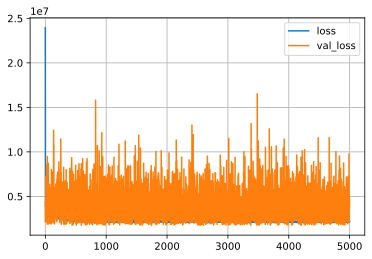

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss, label='loss')
plt.plot(np.arange(len(val_loss)), val_loss, label='val_loss')
plt.grid()
plt.legend()
plt.show()

## 結果の確認

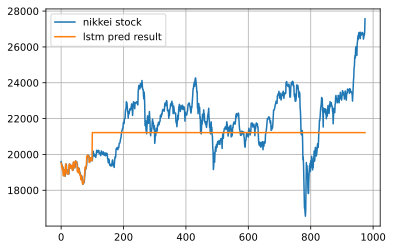

In [23]:
# 初期の入力値
res = l_y[0].reshape(-1)

for i in range(0, n):
  _y = model.predict(res[- NUM_LSTM:].reshape(1, NUM_LSTM, 1))
  res = np.append(res, _y[0][NUM_LSTM - 1][0])
  
plt.plot(np.arange(len(y)), y, label="nikkei stock")
plt.plot(np.arange(len(res)), res, label="lstm pred result")
plt.legend()
plt.grid()
plt.show()

In [25]:



import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row),:]
    np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(input_shape = (layers[1], layers[0]),
                    output_dim=layers[1],
                    return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer='rmsprop')
    print(" 実行時間：　", time.time() - start)
    return model

def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

 import os
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'rb').read()
    data = f.decode().split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row),:]
    np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(input_shape = (layers[1], layers[0]),
                    output_dim=layers[1],
                    return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(layers[2],return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer='rmsprop')
    print(" 実行時間：　", time.time() - start)
    return model

def predict_point_by_point(model, data):
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs
 
"""
model.fit(X_train, y_train, batch_size=512, nb_epoch=epoch, validation_split=0.05)
predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
model = lstm.build_model([1, 50, 100, 1])
"""


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 92)